# Основы программирования в Python

*Алла Тамбовцева*

## Моделирование с `gensim`. Модель Doc2Vec и LDA.

### Подготовка данных

Загрузим данные из файла *articles.csv* и приведем текст к нормальной форме, используя написанные в предыдущей части функции.

In [1]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/allatambov/Py-programming-3/master/add/articles.csv', encoding= 'UTF-8')

In [2]:
# нижний регистр и удаление пунктуации
import string
def normalize(x):
    to_remove = string.punctuation + '«»—'
    translator = str.maketrans('', '', to_remove)
    res = x.translate(translator)
    res = res.lower()
    return res

In [3]:
# удаление русских стоп-слов и создание списка слов
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

def filter_words(text, lang = 'russian'):
    
    wordsFiltered = []
    stopWords = set(stopwords.words(lang))
    words = word_tokenize(text)

    for w in words:
        if w not in stopWords:
            wordsFiltered.append(w)
    return wordsFiltered

In [4]:
# применяем
df['text_norm'] = df.text.apply(normalize)
df['words'] = df.text_norm.apply(filter_words)
df

,text,text_norm,words
0,Что такое сверхтекучесть? Нам известно одно ее...,что такое сверхтекучесть нам известно одно ее ...,"[такое, сверхтекучесть, нам, известно, одно, п..."
1,"Тут возникают новые вопросы о том, как вообще ...",тут возникают новые вопросы о том как вообще м...,"[возникают, новые, вопросы, вообще, сравнить, ..."
2,Еще одно интересное употребление редупликации ...,еще одно интересное употребление редупликации ...,"[одно, интересное, употребление, редупликации,..."
3,Как устроены эти редупликации типа «маслице-фи...,как устроены эти редупликации типа маслицефига...,"[устроены, редупликации, типа, маслицефигаслиц..."
4,Курс «Расстройства личности: от паранойи и ист...,курс расстройства личности от паранойи и истер...,"[курс, расстройства, личности, паранойи, истер..."
5,Сопротивление соблазну. В экономических термин...,сопротивление соблазну в экономических термина...,"[сопротивление, соблазну, экономических, терми..."
6,В этом смысле такое картирование может быть ос...,в этом смысле такое картирование может быть ос...,"[смысле, такое, картирование, осуществлено, лю..."
7,"Существует широко распространенное убеждение, ...",существует широко распространенное убеждение ч...,"[существует, широко, распространенное, убежден..."


### Doc2Vec c  `gensim`

Задача метода *Doc2Vec*, как следует из названия, ‒ представить документы (тексты) в виде числовых векторов. Для того, чтобы понять, как устроен перевод документов в векторы, рассмотрим простейший пример.

У нас есть три текста, которые состоят всего из двух слов (двумерный случай легко оказать на графике).

*Текст 1:*

    бутявка кролик бутявка бутявка бутявка бутявка 

*Текст 2:*

    кролик кролик бутявка кролик
    
*Текст 3:*

    бутявка кролик кролик бутявка
    
Посчитаем, сколько раз в текстах содержатся слова *бутявка* и *кролик*. Построим матрицу (таблицу частот):

In [9]:
d = pd.DataFrame([[5, 1, 2], [1, 3, 2]]).T
d.columns = ['бутявка', 'кролик']
d.index = ['Текст1', 'Текст2', 'Текст3']
d

,бутявка,кролик
Текст1,5,1
Текст2,1,3
Текст3,2,2


Теперь скажем, что частоты в строках ‒ это координаты вектора, соответствующего определенному документу. Так, вектор для первого текста имеет координаты (5, 1), для второго ‒ (1, 3) и для третьего ‒ (2, 2). Осталось представить эти векторы в пространстве слов, которые есть в нашем словаре (их всего два). Другими словами, *бутявка* и *кролик* будут осями координат, вдоль которых будут располагаться векторы документов. Посмотрим на картинку.

In [23]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

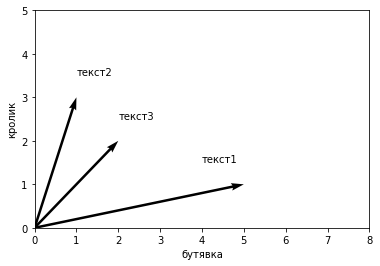

In [32]:
V = np.array([[5, 1],[1, 3],[2, 2]])
origin = [0], [0] 
plt.quiver(*origin, V[:, 0], V[:, 1], angles='xy', scale_units='xy', scale=1)
plt.xlim(0, 8)
plt.ylim(0, 5)
plt.xlabel('бутявка')
plt.ylabel('кролик')
plt.text(4, 1.5, 'текст1')
plt.text(1, 3.5, 'текст2')
plt.text(2, 2.5, 'текст3')

Какую информацию мы можем извлечь из этого графика? Во-первых, то, что слова *бутявка* и *кролик* в данной модели считаются несвязанными (оси перпендикулярны друг другу). Во-вторых, видно, что текст 1 в большей степени посвящен бутявкам, так как соответствующий вектор ближе к оси `x`. В-третьих, видно, что текст 2 больше о кроликах, так как угол между этим вектором и осью `y` наименьший. Текст 3 находится "посередине", то есть он в равной степени и о бутявках, и о кроликах. 

Близость между документами можно определять по углу между соответствующими векторами: чем меньше угол, тем ближе тексты к друг другу по смыслу. На основе этой идеи строится кластеризация текстов: считается косинус угла между векторами, соответствующими каждой паре документов, затем на основе [косинусной меры близости](https://ru.wikipedia.org/wiki/%D0%92%D0%B5%D0%BA%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C) вычисляется расстояние, и далее полученное расстояние можно использовать для реализации кластерного анализа.

В общем случае, когда в словаре $N$ слов, а документов $m$, эти $m$ векторов располагаются в $N$-мерном пространстве, и, хотя представить себе это невозможно, определить углы между векторами и посчитать косинусную близость можно достаточно легко (правда, при больших $N$ и $m$ небыстро). Кроме того, в более реалистичных задачах частота, с которой встречается каждое слово, определяется иначе. Вместо обычной частоты считается [мера](https://ru.wikipedia.org/wiki/TF-IDF) *tf-idf* (*term frequency - inverse document frequency*), которая позволяет оценить важность слова в контексте документа, а не просто число его вхождений в текст. Другими словами, эта мера помогает снизить значимость часто встречаемых слов, если они не несут в себе особенной информации о документе, и, наоборот, повысить значимость более редких слов, которые являются характерными для данного текста.

Теперь, когда мы разобрали саму идею Doc2Vec, можно приступить к его реализации. Импортируем класс `Doc2Vec` из модуля `models` библиотеки `gensim` и класс `TaggedDocument` для создания корпуса (набора документов). Библиотека `gensim` ‒ популярная [библиотека](https://radimrehurek.com/gensim/) для машинного обучения и, прежде всего, для текстового моделирования (Word2Vec, Doc2Vec, LDA, LSA и проч.). 

In [33]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

Slow version of gensim.models.doc2vec is being used


Создадим список текстов, чтобы на его основе составить корпус, объект класса `TaggedDocument`, с обычным списком или словарем модель Doc2Vec работать не будет! Корпус ‒ это набор пар *id документа-текст документа*. Поскольку тексты у нас учебные, без заголовков и меток, в качестве *id* возьмем порядковый номер текста в таблице (через *enumerate*).

In [34]:
Texts = list(df.words)

docs = []
for i, text in enumerate(Texts):
    docs.append(TaggedDocument(text, [i])) # тэг обязательно должен быть списком, поэтому [i]

Посмотрим, что получилось:

In [35]:
docs

[TaggedDocument(words=['такое', 'сверхтекучесть', 'нам', 'известно', 'одно', 'проявление', 'способность', 'вещества', 'течь', 'трения', 'возьмете', 'ведро', 'гелия', 'поместите', 'любую', 'емкость', 'можете', 'двигать', 'вверх', 'вниз', 'стенками', 'емкости', 'возникнет', 'никакого', 'трения', 'сверхтекучесть', 'открыта', 'гелии4', 'объяснена', 'помощи', 'конденсата', 'бозе', 'эйнштейна', 'атомы', 'гелия4', 'существуют', 'форме', 'бозонов', 'могут', 'формировать', 'микроскопическое', 'квантовое', 'состояние', 'конденсат', 'бозе', 'эйнштейна', 'обычно', 'конденсаты', 'бозе', 'эйнштейна', 'это', 'сверхтекучие', 'материалы', 'менее', 'следует', 'сводить', 'друг', 'другу', 'например', 'сверхтекучем', 'гелии4', 'сила', 'взаимодействия', 'намного', 'других', 'сверхтекучих', 'материалах', 'поэтому', 'общая', 'картина', 'немного', 'сложнаяв', 'целом', 'состоянии', 'сверхтекучести', 'частицы', 'складываются', 'микроскопическое', 'квантовое', 'состояние', 'действуют', 'коллективно', 'наталкивают

Теперь создадим модель.

In [36]:
model = Doc2Vec()
model

Составим словарь (набор всех слов в тексте с id):

In [37]:
model.build_vocab(docs)

Осталось построить модель, прогнать ее 10 раз (10 "эпох"):

In [38]:
for epoch in range(10):
    model.train(docs)
    model.alpha -= 0.002  # уменьшить learning rate`
    model.min_alpha = model.alpha

/home/oem/.local/lib/python3.5/site-packages/gensim/models/word2vec.py:772: UserWarning: C extension not loaded for Word2Vec, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn("C extension not loaded for Word2Vec, training will be slow. "


Если Python выдает ошибку, посмотрите, что он пишет. Часто достаточно добавить дополнительные аргументы в `train()`, например, число эпох, равное 10 или еще что-нибудь.

Чтобы не прогонять модель заново при каждом запуске файла (особенно актуально в случае сложных моделей, которые обучаются несколько часов, а то и дней), ее можно сохранить в файл, а потом просто загрузить и продолжить с ней работать.

In [39]:
model.save('d2v_model') # сохраняем
model = Doc2Vec.load('d2v_model') # открываем

In [40]:
model.corpus_count # сколько документов в корпусе

8

Посмотрим на самые близкие к документу с индексом 0 тексты: 

In [41]:
model.docvecs.most_similar([0]) # от самого близкого до самого далекого

[(5, 0.12205836921930313),
 (7, 0.050673384219408035),
 (6, 0.03967006132006645),
 (1, 0.022813543677330017),
 (3, 0.01584635302424431),
 (2, -0.024669073522090912),
 (4, -0.10029617697000504)]

Посмотрим на сами тексты.  

In [42]:
df.text_norm[0]

'что такое сверхтекучесть нам известно одно ее проявление  способность вещества течь без трения если вы возьмете ведро гелия и поместите его в любую емкость вы можете двигать его вверх и вниз а между стенками емкости не возникнет никакого трения сверхтекучесть была открыта в гелии4 и объяснена при помощи конденсата бозе  эйнштейна потому что атомы гелия4 существуют в форме бозонов и могут формировать микроскопическое квантовое состояние  конденсат бозе  эйнштейна обычно конденсаты бозе  эйнштейна  это и есть сверхтекучие материалы тем не менее их не следует сводить друг к другу например в сверхтекучем гелии4 сила взаимодействия намного больше чем в других сверхтекучих материалах поэтому общая картина немного более сложнаяв целом в состоянии сверхтекучести частицы складываются в микроскопическое квантовое состояние и действуют коллективно если они наталкиваются на препятствие они не рассеиваются если смотреть на это с точки зрения энергии то можно понять что любые возбуждения вне этих м

In [43]:
df.text_norm[5]

'сопротивление соблазну в экономических терминах поведение группы характеризовалось динамической несогласованностью сначала а было предпочтительным относительно б а затем приоритет перешел к б динамическая несогласованность  нередкое явление субботним утром люди заявляют что лучше займутся физкультурой чем будут сидеть перед телевизором к полудню они все еще дома на диване смотрят футбол чем объяснить такое поведение\nв случае с кешью действуют два фактора искушение и бездумность понятие искушения занимает человеческие умы по меньшей мере со времен адама и евы для теории подталкивания оно также важно что мы подразумеваем когда говорим о соблазнительном искушающем'

На первый взгляд, документы как-то непохожи. Это очень логично, так как мы обучали модель всего на восьми коротеньких текстах, что явно недостаточно. С другой стороны, если вчитаться, сходство по словам найти можно: и там, и там речь идет о сопротивлении, возбуждении. Для получения более ярких результатов нужно брать более объемный корпус текстов и желательно с более длинными текстами. Но такие модели, скорее всего, будут долго обучаться, и их мы сегодня строить не будем. Можете попробовать сами, нагуглив какой-нибудь корпус новостных статей. Возможно, позже в порыве вдохновения я выложу какие-то результаты на более объемных корпусах.

### LDA: латентное размещение Дирихле

Теперь перейдем к тематическому моделированию ‒ распределению текстов по темам (какие темы на основе имеющихся текстов можно выделить, и какие тексты к ним относятся). Один из самых распространенных методов в тематическом моделировании ‒ это латентное размещение Дирихле (*LDA*, *Latent Dirichlet Allocation*). Прежде чем знакомиться с идеей этого метода, имеет смысл обсудить, причем тут Дирихле. 

Основное предположение LDA заключается в том, что любой текст (документ) ‒ это смесь разных тем. Какая-то тема выражена более ярко, какая-то менее, какая-то совсем не представлена. Удобно представлять себе задачу распределения текстов по темам, проводя аналогию с экзаменационным заданием по иностранному языку, в котором необходимо сопоставить отрывки и заголовки. В каждом отрывке будет по чуть-чуть упоминаться практически каждая тема, связывающая заголовки, но главная тема будет одна. [Распределение Дирихле](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%94%D0%B8%D1%80%D0%B8%D1%85%D0%BB%D0%B5) ‒ это непрерывное многомерное распределение. Его можно задать параметром $\alpha$ ‒ вектором длины $K$ вида ($\alpha_1$, $\alpha_2$, $\dots$, $\alpha_K$), где все $\alpha_i$ лежат в пределах от 0 до 1, и сумма всех $\alpha_i$ равна 1. Если присмотреться, можно заметить, что этот вектор $\alpha$ хорошо описывает текст! Мы фиксируем $K$ ‒ число тем, которые можно выделить, а затем для каждого текста определяем $\alpha = (\alpha_1, \alpha_2, \dots, \alpha_K$), то есть фиксируем вероятности $\alpha_i$, с которыми каждая тема встречается в документе. Вероятности всегда лежат в пределах от 0 до 1, и их сумма равна 1 (конечно, речь идет о взаимоисключающих событиях).

Как происходит обучение модели LDA? Мы фиксируем число тем $K$, исходя из наших содержательных соображений. Для каждого документа создается вектор $\alpha$ длины $K$, элементы которого (вероятности встретить ту или иную тему) считаются так: в самом начале каждому слову в документе случайным образом присваивается тема, а затем вычисляется доля слов, относящихся к каждой теме. Далее вероятности в векторе $\alpha$ считаются более разумным способом: на основе посчитанных условных вероятностей: вероятность встретить определенную тему в данном документе ($\texttt{тема|документ}$) и вероятность встретить определенное слово в рамках данной темы ($\texttt{слово|тема}$). Подробнее о механизме см. [здесь](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/). На выходе модель выдает список тем и топовые (часто встречающиеся) слова в рамках каждой темы.

Основная идея метода зафиксирована, давайте реализуем свой LDA! Работать, правда, будем тоже с учебными данными, совсем небольшим корпусом англоязычных текстов, которые были взяты (и сокращены) из [20 Newsgroups data set](http://qwone.com/~jason/20Newsgroups/). Можете пройти по ссылке, скачать все 20000 текстов (сами тексты небольшие, распакованный архив займет около 50 Мб) и построить более внятную тематическую модель.

Загрузим тексты из файла csv:

In [44]:
d = pd.read_csv('https://raw.githubusercontent.com/allatambov/Py-programming-3/master/add/your_turn.csv')
d.head()

,post
0,When they are victimized they are Muslims. Whe...
1,"But, if you were to discuss the merits of raci..."
2,Why do you restrict your condemnation of racia...
3,"Do you have a strange definition of ""winning""..."
4,In article <kmitchelC4wA87.HLz@netcom.com kmi...


Выполним предварительную обработку текстов (переопределим функцию `filter_words()`, чтобы она убирала английские стоп-слова, а лучше создадим новую с окончанием `_en`):

In [46]:
def filter_words_en(text, lang = 'english'):
    
    wordsFiltered = []
    stopWords = set(stopwords.words(lang))
    words = word_tokenize(text)

    for w in words:
        if w not in stopWords:
            wordsFiltered.append(w)
    return wordsFiltered

In [47]:
d['text_norm'] = d.post.apply(normalize)
d['words'] = d.text_norm.apply(filter_words_en)

Импортируем класс `LdaModel`и модуль `corpora` для создания словаря (перечня всех слов).

In [48]:
from gensim.models.ldamodel import LdaModel
from gensim import corpora

Создадим список текстов `texts`, на его основе создадим словарь `dict_`. Затем создадим корпус текстов.

In [49]:
texts = list(d.words)
dict_ = corpora.Dictionary(texts)
corpus =  [dict_.doc2bow(text) for text in texts]

Осталось построить саму модель. Давайте считать, что в нашем наборе текстов присутствует пять тем (примерно так я их и отбирала: политика, религия, медицина, технологии, атеизм).

In [50]:
lda = LdaModel(corpus, num_topics=5, id2word = dict_)

При построении модели очень важно указать аргумент `id2word` и подставить в него созданный на предыдущем шаге словарь. Если этого не сделать, ничего страшного не случится, но тогда вместо самых распространенных слов в пределах каждой темы мы будем видеть их индексы. Конечно, можно найти слово по индексу в словаре, но это неудобно, учитывая, что слов обычно требуется немало.

Выведем 5 тем и топовые слова для каждой темы (30 слов):

In [53]:
lda.print_topics(5, num_words=30)

[(0,
  '0.007*"would" + 0.005*"one" + 0.004*"look" + 0.004*"like" + 0.004*"much" + 0.004*"lcd" + 0.003*"know" + 0.003*"people" + 0.003*"baseball" + 0.003*"board" + 0.003*"probably" + 0.003*"muslims" + 0.003*"dont" + 0.003*"since" + 0.003*"could" + 0.003*"good" + 0.003*"also" + 0.002*"first" + 0.002*"things" + 0.002*"believe" + 0.002*"im" + 0.002*"time" + 0.002*"even" + 0.002*"racism" + 0.002*"well" + 0.002*"right" + 0.002*"weight" + 0.002*"game" + 0.002*"bad" + 0.002*"use"'),
 (1,
  '0.006*"one" + 0.005*"like" + 0.004*"dram" + 0.004*"use" + 0.004*"would" + 0.004*"health" + 0.003*"know" + 0.003*"dont" + 0.003*"anyone" + 0.003*"wont" + 0.003*"done" + 0.003*"insurance" + 0.003*"ive" + 0.003*"care" + 0.002*"may" + 0.002*"think" + 0.002*"blood" + 0.002*"though" + 0.002*"another" + 0.002*"private" + 0.002*"believe" + 0.002*"really" + 0.002*"make" + 0.002*"good" + 0.002*"im" + 0.002*"get" + 0.002*"cancer" + 0.002*"hospitals" + 0.002*"problem" + 0.002*"abortion"'),
 (2,
  '0.005*"one" + 0.005*

В очередной раз убедились, что а) работать с маленьким корпусом текстов бессмысленно, б) нужно лучше "вычищать" тексты от стоп-слов, добавляя свои слова в "черный" список. Что будет, если мы попробуем выделить больше тем?

In [56]:
lda = LdaModel(corpus, num_topics=8, id2word = dict_)

In [57]:
lda.print_topics(8, num_words=30)

[(0,
  '0.007*"dram" + 0.006*"would" + 0.005*"know" + 0.005*"use" + 0.004*"first" + 0.004*"seats" + 0.004*"home" + 0.004*"two" + 0.003*"data" + 0.003*"game" + 0.003*"chip" + 0.003*"baseball" + 0.003*"runs" + 0.003*"second" + 0.003*"one" + 0.003*"like" + 0.003*"anyone" + 0.003*"look" + 0.003*"power" + 0.003*"get" + 0.003*"dont" + 0.003*"could" + 0.002*"may" + 0.002*"another" + 0.002*"win" + 0.002*"handle" + 0.002*"1" + 0.002*"powerbook" + 0.002*"time" + 0.002*"picture"'),
 (1,
  '0.004*"since" + 0.004*"would" + 0.004*"people" + 0.003*"think" + 0.003*"one" + 0.003*"time" + 0.003*"know" + 0.003*"first" + 0.003*"board" + 0.003*"going" + 0.003*"driving" + 0.003*"make" + 0.002*"like" + 0.002*"right" + 0.002*"cancer" + 0.002*"use" + 0.002*"era" + 0.002*"get" + 0.002*"im" + 0.002*"much" + 0.002*"well" + 0.002*"situation" + 0.002*"aux" + 0.002*"brain" + 0.002*"smoking" + 0.002*"good" + 0.002*"point" + 0.002*"drinking" + 0.002*"quite" + 0.002*"others"'),
 (2,
  '0.006*"one" + 0.006*"like" + 0.00

Наверное, результаты получились чуть более разумным :) По крайней мере, здесь можно выделить темы *религия*, *политика* и *спорт*. Но, конечно, работать с таким малым числом документов несерьезно, этот пример был больше техническим, иллюстрирующим то, каким образом можно предобработать текст, сформировать корпус и обучить модель LDA.

Возможно, позже я выложу более реалистичные примеры с LDA на большом объеме данных + дополню модель разными визуализациями, например, облаками слов для каждой темы.